In [1]:
# ================================================================
# Bachelor Thesis — Fairness in Toxic Comment Classification
# ---------------------------------------------------------------
# Notebook: base_model_training_and_evaluation.ipynb
# Author: Philipp Stocker
# Created: 14.11.2025
# Purpose: TODO: fill purpose
# ================================================================

# --- Basic setup ---
import os
import sys
import warnings
warnings.filterwarnings("ignore")  # keep output clean for reports

# Automatically add project root to path so src/ modules are importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Standard imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from src.modeling import train_lr_tfidf
from src.modeling import predict_with_model
from src.modeling import extract_feature_and_label_arrays
from src.modeling import find_best_threshold

from src.metrics import compute_overall_metrics
from src.metrics import evaluate_subgroups

from src.visualization import (
    plot_performance_bar,
    plot_roc_curve,
    plot_pr_curve,
    plot_confusion_matrix,
    plot_auc_bars,
    plot_rate_gaps_bars,
    print_small_sample_warnings
)

# --- "Global variables" ---
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")

IDENTITY_COLUMNS = ["male", "female", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "transgender", "other_gender", "other_sexual_orientation"]

print("✅ Environment ready")


✅ Environment ready


Load feature and label arrays

In [2]:
x_train, y_train = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "train_tfidf_bundle.joblib")))
x_val, y_val = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_threshold_tfidf_bundle.joblib")))
x_test, y_test = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "test_tfidf_bundle.joblib")))

In [3]:
print(x_test)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 10857415 stored elements and shape (270731, 1039908)>
  Coords	Values
  (0, 27110)	0.07097554206848145
  (0, 27384)	0.15756642818450928
  (0, 78683)	0.058343347162008286
  (0, 79745)	0.09666548669338226
  (0, 116977)	0.06878028064966202
  (0, 117720)	0.12629744410514832
  (0, 125715)	0.09578461199998856
  (0, 138843)	0.14490413665771484
  (0, 142517)	0.15484090149402618
  (0, 173260)	0.07230617105960846
  (0, 173736)	0.13408198952674866
  (0, 173779)	0.07682445645332336
  (0, 174063)	0.14753539860248566
  (0, 175774)	0.07738008350133896
  (0, 202639)	0.07148492336273193
  (0, 203110)	0.12677647173404694
  (0, 239954)	0.08897945284843445
  (0, 290895)	0.08596064895391464
  (0, 290933)	0.14046761393547058
  (0, 317950)	0.08118438720703125
  (0, 318059)	0.14788880944252014
  (0, 364430)	0.16102655231952667
  (0, 373432)	0.07032155245542526
  (0, 373661)	0.1344558745622635
  (0, 376679)	0.07672189921140671
  :	:
  (270728, 93151

BASE MODEL TRAINING

Train base model including hyperparameter tuning and calibration

In [3]:
# Train base model: Logistic Regression with TF-IDF features (per default with hyperparameter tuning and calibration)
base_models = train_lr_tfidf(
    x_train=x_train,
    y_train=y_train
)

# Save trained base models
joblib.dump(base_models, project_root + "/models/tfidf_base_models.joblib")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  34.5s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  33.2s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  32.6s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  24.7s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  25.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  19.2s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  17.5s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  18.7s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  18.7s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  17.5s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  38.2s
[CV] END C

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/models/tfidf_base_models.joblib']

BASE MODEL EVALUATION

Load base models for further evaluation

In [3]:
base_models = joblib.load(project_root + "/models/tfidf_base_models.joblib")

Calculate best threshold based on f1 score

In [4]:
y_val_proba, _ = predict_with_model(base_models["model"], x_val, threshold=0.5)

threshold = find_best_threshold(y_val, y_val_proba)

Best threshold: 0.25 with F1-score: 0.6447


Conduct prediction on test dataset and print result

In [5]:
y_test_proba, y_test_pred = predict_with_model(base_models["model"], x_test, threshold=threshold)

# Calculate and print number of toxic and non-toxic comments in test set
count_toxic = np.sum(y_test_pred)
count_nontoxic = len(y_test_pred) - count_toxic
print(f"Number of toxic comments: {count_toxic}")
print(f"Number of non-toxic comments: {count_nontoxic}")    

Number of toxic comments: 22661
Number of non-toxic comments: 248070


Optional: conduct prediction on test dataset with uncalibrated model for comparision

In [8]:
if base_models["uncalibrated_model"] is not None:
    y_test_proba_uncalibrated, y_test_pred_uncalibrated = predict_with_model(base_models["uncalibrated_model"], x_test, threshold=threshold)
    count_toxic_uncalibrated = np.sum(y_test_pred_uncalibrated)
    count_nontoxic_uncalibrated = len(y_test_pred_uncalibrated) - count_toxic_uncalibrated
    print(f"Number of toxic comments (uncalibrated): {count_toxic_uncalibrated}")
    print(f"Number of non-toxic comments (uncalibrated): {count_nontoxic_uncalibrated}")

Number of toxic comments (uncalibrated): 70445
Number of non-toxic comments (uncalibrated): 200286


BASE MODEL PERFORMANCE METRICS

Calculate performance metrics

In [6]:
base_model_overall_metrics = compute_overall_metrics(y_test, y_test_pred, y_test_proba)

# Print and save overall metrics
print("Overall metrics for base model:")
print(base_model_overall_metrics)

joblib.dump(base_model_overall_metrics, project_root + "/results/tfidf_base_model_overall_metrics.joblib")

Overall metrics for base model:
{'accuracy': 0.94105588203789, 'precision': 0.6256122854242973, 'recall': 0.6547965451942174, 'f1_score': 0.6398718180176928, 'roc_auc': 0.9483893764015319, 'pr_auc': 0.6974232009378413}


['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/results/tfidf_base_model_overall_metrics.joblib']

Visualize performance metrics

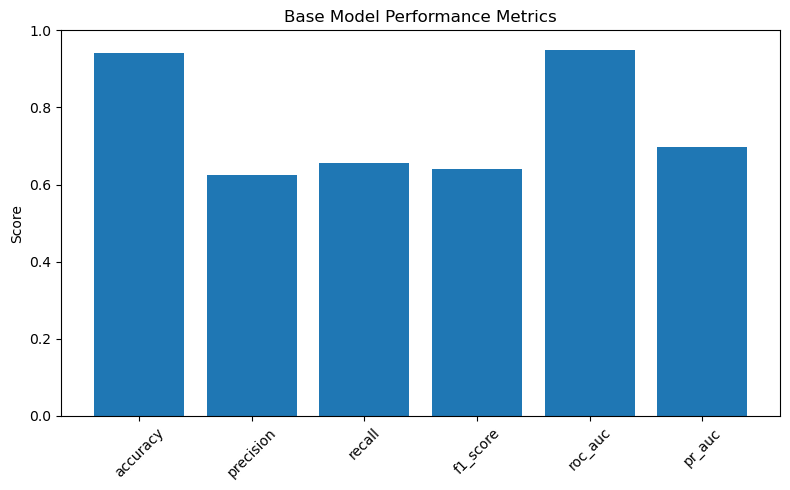

In [8]:
# Plot performance bars
plot_performance_bar(base_model_overall_metrics, title="Base Model Performance Metrics")

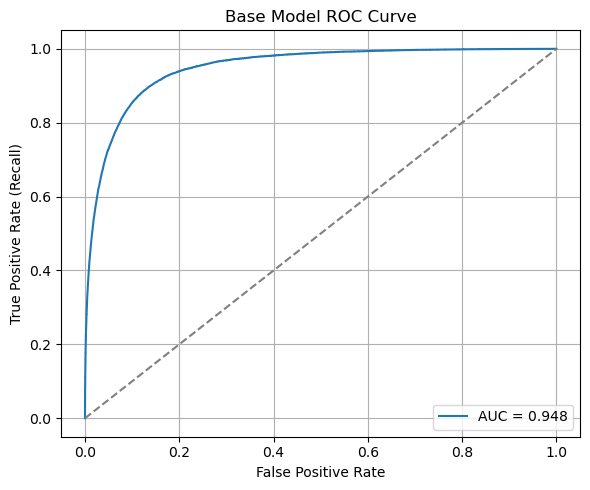

In [9]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_proba, title="Base Model ROC Curve")

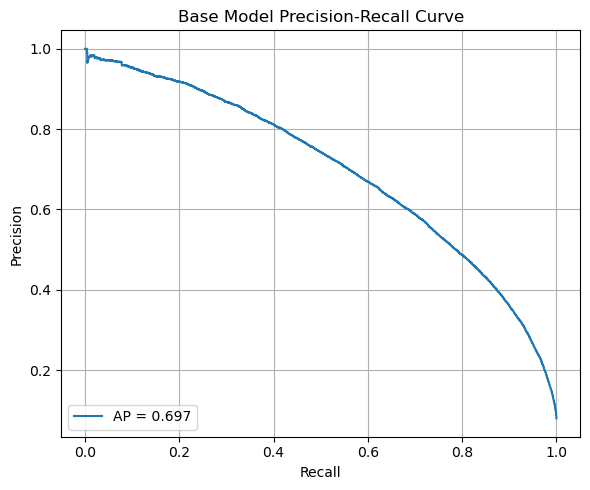

In [10]:
# Plot PR curve
plot_pr_curve(y_test, y_test_proba, title="Base Model Precision-Recall Curve")

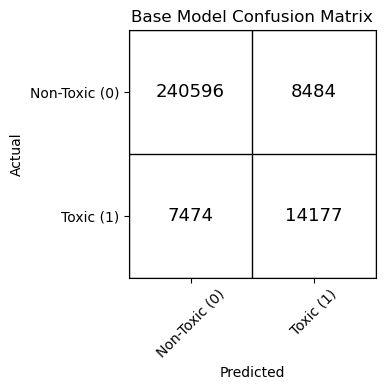

In [11]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, title="Base Model Confusion Matrix")

BASE MODEL FAIRNESS METRICS

Calculate fairness Metrics (per subgroup)

In [7]:
# Prepare test dataframe with predictions for subgroup evaluation
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet")).copy()
test_df["predicted_proba"] = y_test_proba
test_df["predicted_label"] = y_test_pred

test_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,labelled_as_toxic,has_identity,comment_text_processed,predicted_proba,predicted_label
0,5555389,0.1,I listened to Scheer re Omar Khadr; he sounded...,0.0,0.0,0.1,0.1,0.0,NaN,NaN,...,3,2,0.0,0,10,0,0,i listened to scheer re omar khadr he sounded ...,0.044897,0
1,376072,0.0,For more on Pre check out; prespeople.com,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,for more on pre check out prespeople com,0.002610,0
2,539767,0.4,They also have to go to places where people sh...,0.1,0.0,0.0,0.0,0.4,NaN,NaN,...,0,0,0.0,0,10,0,0,they also have to go to places where people sh...,0.384593,1
3,5556650,0.0,This is why many experts and policy makers are...,0.0,0.0,0.2,0.0,0.0,NaN,NaN,...,0,0,0.0,0,5,0,0,this is why many experts and policy makers are...,0.008390,0
4,333126,0.0,"Yeah, I know...many regular miles as well.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,yeah i know many regular miles as well,0.010261,0


In [8]:
# Conduct subgroup evaluation
subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    threshold=threshold
)

# Print subgroup metrics
print(subgroup_metrics_df)

# Save subgroup metrics
joblib.dump(subgroup_metrics_df, project_root + "/results/tfidf_base_model_subgroup_metrics.joblib")

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                       male        6640  264091       985      5655   
5                     female        8107  262624      1093      7014   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.730441  0.790553  0.945316  0.230263  0.513514  0.033942  0.344915   
1      0.765625  0.805735  0.945282  0.218750  0.666667  0.034038  0.345114   
2      0.777140  0.756498  0.964996  0.268696  0.314978  0.032973  0.345851   
3      0.816381  0.809262  0.958938

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/results/tfidf_base_model_subgroup_metrics.joblib']

Visualize fairness metrics (per subgroup)

In [15]:
# Print warnings indicating subgroups with small sample sizes
# This helps to identify potential issues with metric stability due to limited data
print_small_sample_warnings(subgroup_metrics_df)

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0


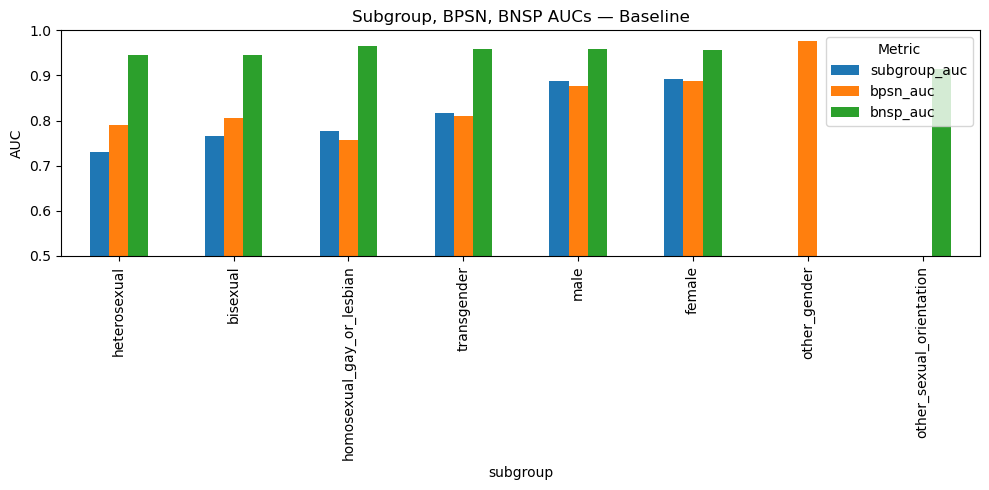

In [16]:
# Visualize auc bars
plot_auc_bars(subgroup_metrics_df)

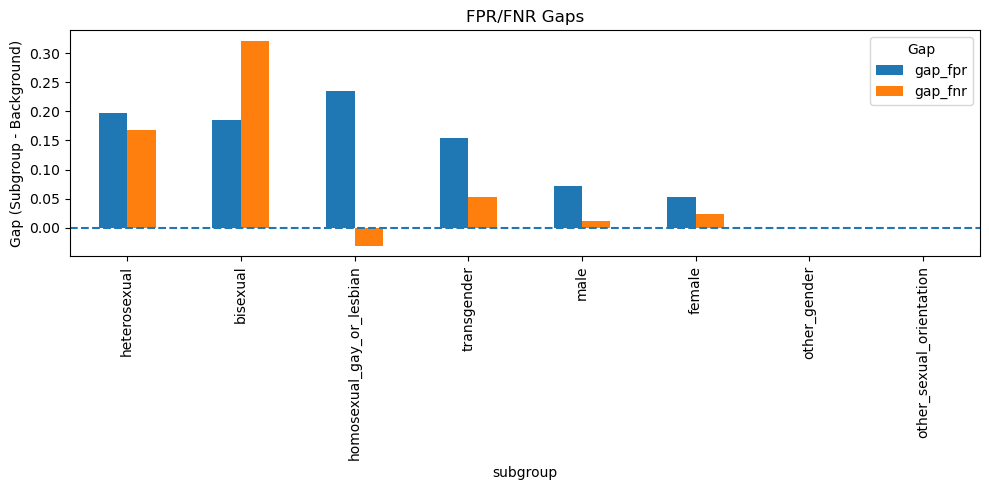

In [17]:
# Visualize fpr/fnr gaps bars
plot_rate_gaps_bars(subgroup_metrics_df)